## Numerical experiments math and Data Science Project
#### Authors: Beltrame and Marchionne

In the following, we are presenting the results of the numerical experiments associated to the following papers:

- Training ReLU networks to high uniform accuracy is intractable; Julius Berner; Philipp Grohs and Felix Voigtlaender


The numerical experiments aim to prove that we can find relevant and domain-specific problems of usign neural networks in solving even simple tasks.


## Target function: x $\rightarrow$ log(sin(50x) + 2) + sin(5x)

In the next line we are implementing a Student Teacher Neural Network regressor.

The Student-Teacher Framework is a machine learning approach where a "student" model is trained to mimic the outputs of a pre-trained "teacher" model. The student model is typically smaller and faster, while the teacher model is larger and slower, but more accurate. During training, the student model is fed input data and its predictions are compared to the ground-truth labels produced by the teacher model. The student model's parameters are then updated based on this comparison, until the student's predictions match the teacher's predictions with high accuracy. The end result is a compact, efficient model that has learned from the knowledge of a larger, more accurate model.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
    
# custom
from Functions import plot_result, MLPRegressor, create_dataset, StudentTeacher, ModelEvaluator, StudentNet, TeacherNet

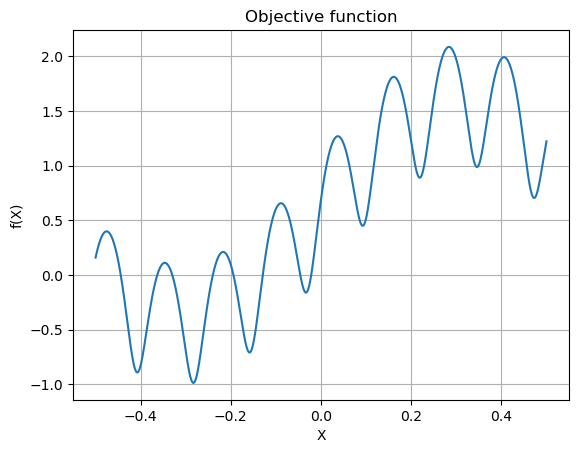

In [2]:
# define x
epsilon = 0.00001
x = np.arange(-0.5, 0.5, epsilon)
x_init = x
function = lambda x : np.log(np.sin(50 * x) + 2) + np.sin(5*x)
fx = [function(e) for e in x]
plot_result(x_init, fx, "X", "f(X)", "Objective function")

x_train, x_test, y_train, y_test = create_dataset(x, fx)



[]

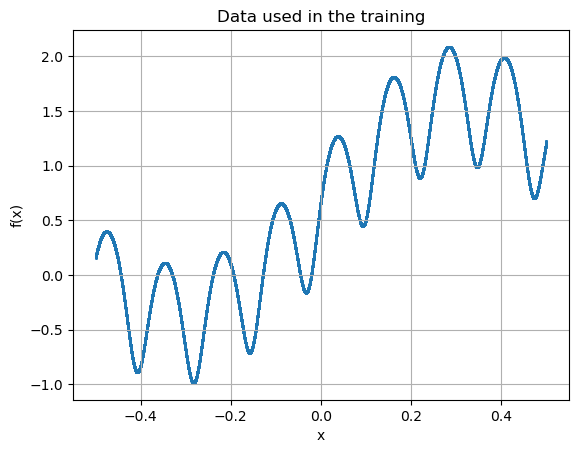

In [3]:
plt.scatter(x_train, y_train, 1)
plt.title("Data used in the training")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.plot()

We are using a support class that takes a *student teacher* neural network.

In [4]:
# width of the student MLP
hidden_size_s = [10, 20, 30]

#define students and teachers networks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a student-teacher object
st = StudentTeacher(device='cuda')

# Train the student network
st.fit(x_train, y_train)

C:\Users\beltr\Documents\GitHub\Math_proj\Functions.py:541: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).to("cuda")
C:\Users\beltr\Documents\GitHub\Math_proj\Functions.py:542: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).view(-1, 1).to("cuda")


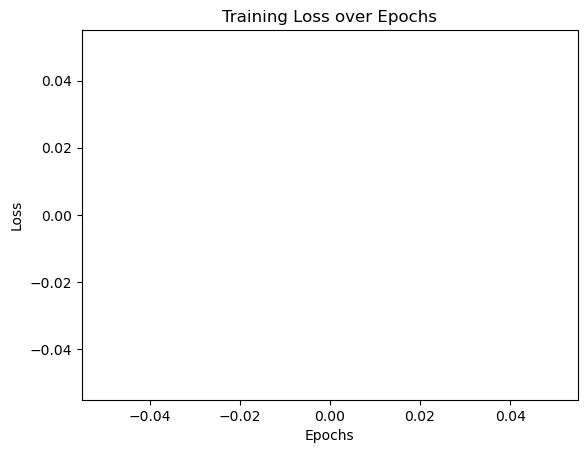

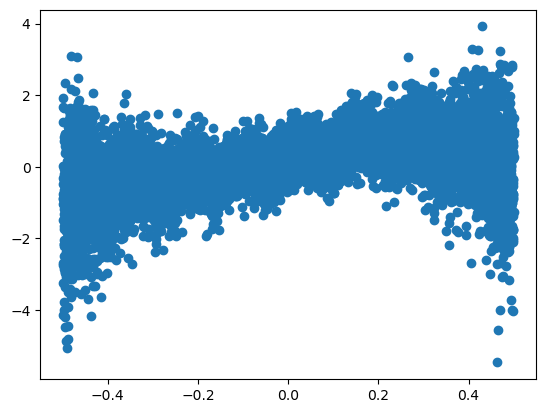

In [5]:
st.plot_loss()
plt.scatter(x_test, st.predict(x_test).cpu().detach().numpy())

In [6]:
# number of trials per layer width
T = 10
evaluator = ModelEvaluator(x_train, x_test, y_train, y_test, hidden_size_s, T)

In [ ]:
evaluator.train_models()

In [ ]:
evaluator.plot_models(R = 20)
plt.plot(x_init, fx, label="Target function")
plt.show()